In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch.utils.data import DataLoader

In [2]:
image_transforms = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from torchvision.datasets import ImageFolder
DATA_DIR = "/content/drive/MyDrive/Assignment1_ML2/dataset"
BATCH_SIZE = 128
dataset = ImageFolder(root=DATA_DIR, transform=image_transforms)
dataloader = DataLoader(dataset,batch_size=BATCH_SIZE,shuffle=True,num_workers=2 )

real_images_batch, _ = next(iter(dataloader))
print(f"Shape of one batch of real images: {real_images_batch.shape}")
print(f"Pixel value minimum: {real_images_batch.min()}")
print(f"Pixel value maximum: {real_images_batch.max()}")

Shape of one batch of real images: torch.Size([128, 3, 32, 32])
Pixel value minimum: -1.0
Pixel value maximum: 1.0


In [19]:
class Discriminator(nn.Module):
    def __init__(self,input_size=3):
        super().__init__()
        self.sequential = nn.Sequential(
            nn.Conv2d(input_size,32,kernel_size=4,padding=1,stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32,64,kernel_size=4,padding=1,stride=2),

            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64,128,kernel_size=4,padding=1,stride=2),

            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128,1,kernel_size=4,padding=0,stride=1),

            nn.Flatten()
        )
    def forward(self,x):
        x = self.sequential(x)
        return x.view(-1)

In [20]:
class Generator(nn.Module):
    def __init__(self,latent_dim=100):
        super().__init__()
        self.linear =nn.Sequential(
            nn.Linear(latent_dim,128*4*4),
            nn.BatchNorm1d(128*4*4),
            nn.ReLU(),
        )
        self.sequential = nn.Sequential(
            nn.ConvTranspose2d(128,64,kernel_size=4,stride=2,padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64,32,kernel_size=4,stride=2,padding = 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32,3,kernel_size=4,stride=2,padding = 1),
            nn.BatchNorm2d(3),
            nn.Tanh()
        )
    def forward(self,x):
        x = self.linear(x)
        x = x.view(-1,128,4,4)
        return self.sequential(x)

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
D = Discriminator().to(device)
G = Generator().to(device)

In [34]:
def discriminator_loss_function(real,fake):
    z = torch.mean((real-1)**2 + fake**2)
    return z *0.5

def generator_loss_function(fake):
    z = torch.mean((fake-1)**2)
    return z*0.5

In [35]:
d_optimizer = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
epochs = 20000

In [36]:
import os
os.makedirs("GAN_results", exist_ok=True)

In [37]:
from torchvision.utils import save_image
import os

g_losses, d_losses = [], []
batch_size = 128


data_iter= iter(dataloader)
D.train()
G.train()

for epoch in range(1, epochs+1):
    try:
        real_images, _ = next(data_iter)
    except:
        data_iter= iter(dataloader)
        real_images, _ = next(data_iter)

    real_batch = real_images[:batch_size].to(device)

    current_batch_size = real_batch.size(0)

    # labels
    real_labels = torch.ones((current_batch_size, 1), device=device)
    fake_labels = torch.zeros((current_batch_size, 1), device=device)


    # Train Discriminator
    z = torch.randn(current_batch_size, 100, device=device)
    with torch.no_grad():
        fake_batch = G(z)

    D_real = D(real_batch)
    D_fake = D(fake_batch.detach())

    d_loss = discriminator_loss_function(D_real,D_fake)


    d_optimizer.zero_grad()
    d_loss.backward()
    d_optimizer.step()


    # Train Generator
    z = torch.randn(current_batch_size, 100,device=device)
    fake_batch = G(z)
    D_fake = D(fake_batch)
    g_loss = generator_loss_function(D_fake)


    g_optimizer.zero_grad()
    g_loss.backward()
    g_optimizer.step()


    g_losses.append(g_loss.item())
    d_losses.append(d_loss.item())

    if epoch % 200 == 0:
        print(f"Step {epoch}, D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")
        G.eval()
        with torch.no_grad():
            z = torch.randn(batch_size,100, device=device) # use full batch size for generating samples
            fake_samples = G(z).detach().cpu()
        save_image(fake_samples, f"GAN_results/epoch_{epoch}.png", normalize=True, nrow=8)
        G.train()

Step 200, D Loss: 0.0180, G Loss: 0.7063
Step 400, D Loss: 0.0150, G Loss: 0.7220
Step 600, D Loss: 0.0270, G Loss: 0.7251
Step 800, D Loss: 0.0124, G Loss: 0.5047
Step 1000, D Loss: 0.0302, G Loss: 0.3512
Step 1200, D Loss: 0.0285, G Loss: 0.3550
Step 1400, D Loss: 0.0323, G Loss: 0.4475
Step 1600, D Loss: 0.0336, G Loss: 0.4933
Step 1800, D Loss: 0.0176, G Loss: 0.5186
Step 2000, D Loss: 0.0324, G Loss: 0.3971
Step 2200, D Loss: 0.0212, G Loss: 0.5554
Step 2400, D Loss: 0.0146, G Loss: 0.4790
Step 2600, D Loss: 0.0278, G Loss: 0.6362
Step 2800, D Loss: 0.0170, G Loss: 0.4468
Step 3000, D Loss: 0.0893, G Loss: 0.2785
Step 3200, D Loss: 0.0168, G Loss: 0.4429
Step 3400, D Loss: 0.0124, G Loss: 0.4661
Step 3600, D Loss: 0.0133, G Loss: 0.5441
Step 3800, D Loss: 0.0261, G Loss: 0.4595
Step 4000, D Loss: 0.0101, G Loss: 0.4869
Step 4200, D Loss: 0.0176, G Loss: 0.5441
Step 4400, D Loss: 0.0175, G Loss: 0.4133
Step 4600, D Loss: 0.0128, G Loss: 0.4218
Step 4800, D Loss: 0.0121, G Loss: 0.5

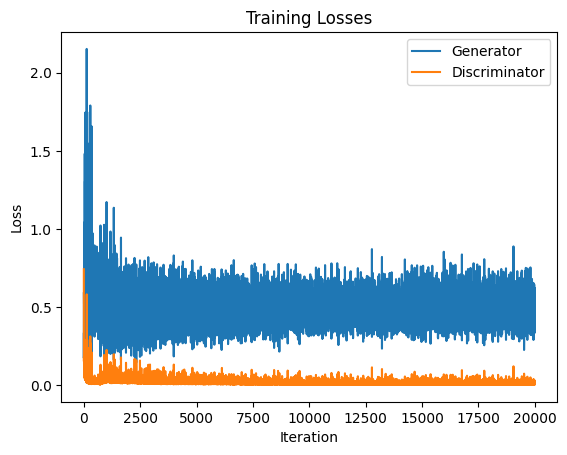

In [43]:
plt.plot(g_losses, label="Generator")
plt.plot(d_losses, label="Discriminator")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.title("Training Losses")
plt.show()

FID Score

In [41]:
os.makedirs("Generated", exist_ok=True)
G.eval()
saved_count = 0
batch_size = 128
with torch.no_grad():
    while saved_count <3000:
        z = torch.randn(batch_size,100,device=device)
        fake_images = G(z).detach().cpu()
        for i in range(fake_images.size(0)):
            if saved_count < 3000:
                save_image(fake_images[j], f"Generated/fake_{saved_count}.png", normalize=True)
                saved_count += 1
            else:
                break



In [39]:
os.makedirs("Real", exist_ok=True)
saved_count = 0
for i, (images_batch, _) in enumerate(dataloader):
    for j in range(images_batch.size(0)):
        if saved_count >= 3000:
            break
        save_image(images_batch[j],f"Real/real_{saved_count}.png",normalize=True)
        saved_count += 1
        
    if saved_count >= 3000:
        break

In [13]:
!pip install torch-fidelity


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [42]:
from torch_fidelity import calculate_metrics

metrics = calculate_metrics(
    input1='Real/',       
    input2='Generated/',  
    fid=True,
    cuda=torch.cuda.is_available()
)

print("FID:", metrics['frechet_inception_distance'])

Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting statistics from input 1
Looking for samples non-recursivelty in "Real/" with extensions png,jpg,jpeg
Found 3000 samples
Processing samples                                                           
Extracting statistics from input 2
Looking for samples non-recursivelty in "Generated/" with extensions png,jpg,jpeg
Found 3000 samples
Processing samples                                                           


FID: 290.0654308884336


Frechet Inception Distance: 290.0654308884336
